# Crypto DEMO

checkign current working directory

datasets are in /Users/42t43/Library/Mobile\ Documents/com\~apple\~CloudDocs/Dev/Python/Deep-Learning/Crypto 

In [4]:
import os

## when setting path, it is very important to know your CURRENT WORKING DIRECTORY (CWY)
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print(cwd, files)

/content ['.config', 'Copy of crypto_data.zip', 'crypto_data.zip', 'Copy of models.zip', 'sample_data']


### uploading crypto dataset and model folder into google colab to store the results

In [0]:
from zipfile import ZipFile
file_name = 'crypto_data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [0]:
from zipfile import ZipFile
file_name = 'models.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

check the data and folder is in your cwd

In [8]:
cwd = os.getcwd() 
files = os.listdir(cwd)
print(cwd, files)

/content ['.config', 'models.zip', 'crypto_data', 'models', 'Copy of crypto_data.zip', 'crypto_data.zip', '__MACOSX', 'Copy of models.zip', 'sample_data']


### preprocessing datasets and creating the model

In [9]:
import pandas as pd
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
from sklearn import preprocessing

SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "BTC-USD"
EPOCHS = 5  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
LEARNING_RATE = 0.001
NAME = f"{RATIO_TO_PREDICT}-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{EPOCHS}-EPOCHS-{BATCH_SIZE}-BATCH-{LEARNING_RATE}-LR-{int(time.time())}"


def classify(current, future):
    if float(future) > float(current):  # if the future price is higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0


def preprocess_df(df):
    df = df.drop("future", 1)  # don't need this anymore.

    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] = df[col].pct_change()  # pct change "normalizes" the different currencies (each crypto coin has vastly diff values, we're really more interested in the other coin's movements)
            df.dropna(inplace=True)  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.

    df.dropna(inplace=True)  # cleanup again... jic.


    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X), y  # return X and y...and make X a numpy array!


main_df = pd.DataFrame() # begin empty

ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]  # the 4 ratios we want to consider
for ratio in ratios:  # begin iteration

    ratio = ratio.split('.csv')[0]  # split away the ticker from the file-name
    print(ratio)
    dataset = f'crypto_data/{ratio}.csv'  # get the full path to the file.
    df = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  # read in specific file

    # rename volume and close to include the ticker so we can still which close/volume is which:
    df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)

    df.set_index("time", inplace=True)  # set time as index so we can join them on this shared time
    df = df[[f"{ratio}_close", f"{ratio}_volume"]]  # ignore the other columns besides price and volume

    if len(main_df)==0:  # if the dataframe is empty
        main_df = df  # then it's just the current df
    else:  # otherwise, join this data to the main one
        main_df = main_df.join(df)

main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)
#print(main_df.head())  # how did we do??

main_df['future'] = main_df[f'{RATIO_TO_PREDICT}_close'].shift(-FUTURE_PERIOD_PREDICT)
main_df['target'] = list(map(classify, main_df[f'{RATIO_TO_PREDICT}_close'], main_df['future']))

main_df.dropna(inplace=True)

## here, split away some slice of the future data from the main main_df.
times = sorted(main_df.index.values)
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]

validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]

train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)

print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


opt = tf.keras.optimizers.Adam(LEARNING_RATE, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=[tensorboard, checkpoint],
)

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
model.save("models/{}".format(NAME))

BTC-USD
LTC-USD
BCH-USD
ETH-USD


W0807 09:49:53.608708 140567484561280 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


train data: 83156 validation: 4478
Dont buys: 41578, buys: 41578
VALIDATION Dont buys: 2239, buys: 2239
Train on 83156 samples, validate on 4478 samples
Epoch 1/5
   64/83156 [..............................] - ETA: 1:42:50 - loss: 1.0800 - acc: 0.4844

W0807 09:50:03.668107 140567484561280 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.259933). Check your callbacks.


83156/83156 [==============================] - 29s 351us/sample - loss: 0.7103 - acc: 0.5333 - val_loss: 0.6808 - val_acc: 0.5641
Epoch 2/5
83156/83156 [==============================] - 24s 285us/sample - loss: 0.6803 - acc: 0.5648 - val_loss: 0.6786 - val_acc: 0.5648
Epoch 3/5
83156/83156 [==============================] - 24s 287us/sample - loss: 0.6755 - acc: 0.5787 - val_loss: 0.6730 - val_acc: 0.5820
Epoch 4/5
83156/83156 [==============================] - 24s 288us/sample - loss: 0.6726 - acc: 0.5836 - val_loss: 0.6735 - val_acc: 0.5824
Epoch 5/5
83156/83156 [==============================] - 24s 288us/sample - loss: 0.6705 - acc: 0.5884 - val_loss: 0.6789 - val_acc: 0.5732
Test loss: 0.6788632626403598
Test accuracy: 0.57324696


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 60, 128)           70656     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 60, 128)           132096    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 128)           512       
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               1

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

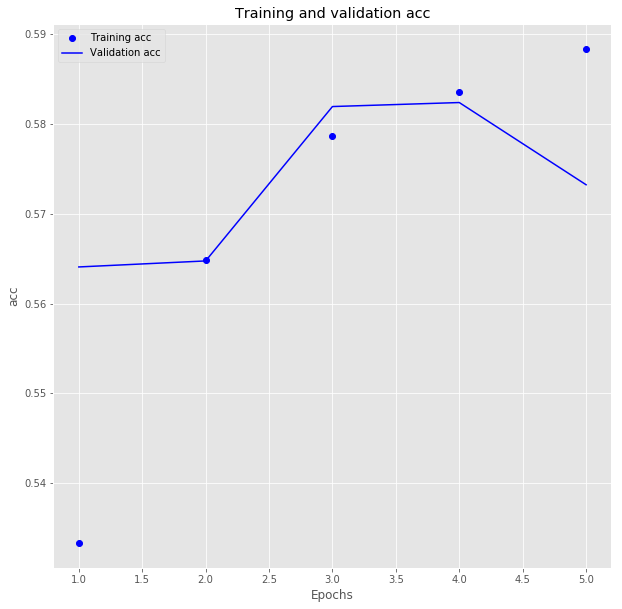

In [12]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.style.use('ggplot')
plt.figure(figsize=(10,10))
plt.plot(epochs, acc, 'bo', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

### selecting the best model

In [0]:
model = tf.keras.models.load_model('models/RNN_Final-03-0.579.model')

In [0]:
model.summary()

### testing the model

In [13]:
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6788632626403598
Test accuracy: 0.57324696


### testing with different model

In [0]:
model = tf.keras.models.load_model('models/RNN_Final-10-0.559.model')

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])